<h1><center>Airborne Infection Risk Estimator for Indoor Environments
</center></h1>

<center>By Etienne Doidic, Zhexu Li, and Nicholas Kho <center>

The global pandemic of COVID-19 has demonstrated the exceptional transmissibility of the SARS-CoV-2 virus and has highlighted the vulnerability of the built environment to airborne pathogens. 
As buildings today reopen it is important to understand the risk of airborne infection based on building and occupant features, for not only the current pandemic, but for future ones as well. One method that has been developed to address this problem is the infection risk calculator. These calculators allow users to input variables such as the number of occupants,  room dimensions, air change per hour (ACH), masks/no masks, etc., in order to determine the risk of infected person(s) transmitting a virus to susceptible people the room [Lelieveld et al. 2020](https://doi.org/10.3390/ijerph17218114).

While these calculators may be convenient in some cases, they are “black box” algorithms, meaning the underlying code is not accessible or transparent to users. With a large amount of skepticism surrounding the academic literature regarding this virus and its transmission [[Scheirer 2020]](https://doi.org/10.1080/00963402.2020.1778361), we believe it is important infection risk calculators are as transparent as possible. So we have placed all of our assumptions and their sources in assumptions.py, which can be accessed on the user interface website. 

In this notebook we describe our methods for developing our own infection risk algorithm for the SARS-CoV-2 virus, compiling room data from the UC San Diego campus, and compiling it into a website. 

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys_path = os.path.dirname(os.getcwd())
src_path = sys_path + "/src"

sys.path.insert(1, src_path)
from calculator import * 
assumptions = var
src_path = sys_path + "/notebook"

sys.path.insert(1, src_path)


## Airborne Infection Risk Estimator

### How does it Work?

To calculate the risk of infection in a given room, the emmission rate of quanta is needed. A quantum is defined as the viral load i.e. the dose of contaminated airborne droplet nuclei required to cause infection in 63% of persons. 
The emmission rate of quanta is caclulated with the following formula:
![title](images/formula1.1.png)

[Morawska et al. 2020](https://doi.org/10.1016/j.envint.2020.105794)

<b>Ni</b> is the droplet concentrations by diameter in <b>particles per cubic centimeter</b>. The droplet concentrations are dependent on the expiratory activity of the infected person. Droplet concentrations by diameter were taken from [Morawska et al. 2009](https://doi.org/10.1016/j.jaerosci.2008.11.002). "Speaking" was considered to be the average of "singing" and "counting." 

In [2]:
pd.DataFrame(assumptions['droplet_conc'])

,speaking,counting,whispering,singing,breathing
.8μm,0.4935,0.236,0.110,0.751,0.084
1.8μm,0.1035,0.068,0.014,0.139,0.009
3.5μm,0.0730,0.007,0.004,0.139,0.003
5.5μm,0.0350,0.011,0.002,0.059,0.002


<b>cv</b> corresponds to the <b>viral load in the sputum</b> (i.e. infectious mucus) of the infected person, expressed in <b>RNA copies per mililiter</b>. The viral load in sputum of an infected person varies and is dependent on the stage of infection [[Yu et al. 2020]](https://doi.org/10.1186/s13054-020-02893-8).
A range of 1e5 - 1e9 RNA copies per mililiter for viral load in the sputum is determined but for this experiment we will choose the maximum viral load to simulate the worst case scenario for infection spread [[Walsh et al. 2020]](https://doi.org/10.1016/j.jinf.2020.06.067).

<b>ci</b> is a conversion factor defined as the ratio between one infectious quantum and the infectious dose expressed in viral RNA copies, expressed in <b>quanta per RNA copies</b>. A survey of ci's indicates a range of .01 to .1 but finally a ci of .02 was selected to reflect the average value of the infectious doses reported in [Watanabe et al. 2010](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1539-6924.2010.01427.x). The study covers SARS-CoV (not to be confused with SARS-CoV-2, the virus that causes COVID-19) but was selected because it provides a more well-studied report of the infectivity of coronaviruses, which has not possible for SARS-CoV-2 due to its very recent development.

<b>Inhalation Rate (IR)</b> is the product of breathing rate and tidal volume, expressed in <b>cubic meters per hour</b>. IR is dependent on the activity of the infected subject. The following values were chosen from [Adams 1993](https://ww2.arb.ca.gov/sites/default/files/classic//research/apr/past/a033-205.pdf)


Next we must calculate the quanta concentration as a function of time using the following equation:
![title](images/formula1.png)
[Gammaitoni, Nucci 1997](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2627642/)

where <b>IVRR (hr−1)</b> represents the infectious virus removal rate in the space investigated. The infectious virus removal rate (IVRR) is the sum of three parameters [(Yang and Marr, 2011)](https://doi.org/10.1371/journal.pone.0021481): the air change per hour (<b>ACH</b>) via ventilation, the <b>particle deposition</b> on surfaces via gravitational settling, and the <b>viral inactivation rate</b> (i.e. how long the virus remains contagious in aerosol).

<b>n0</b> represents the initial number of quanta in the space

<b>I</b> is the number of infectious subjects, 

<b>V</b> is the volume of the indoor environment considered,

and <b>ERq</b> is the abovementioned quanta emission rate (quanta h−1)

This model was selected because it has been used in previous papers to estimate infection risk of other airborne diseases in indoor environments. For example [Wagner et al. 2009](https://bmcmedicine.biomedcentral.com/articles/10.1186/1741-7015-7-81)

The <b>viral inactivation rate</b> of SARS-CoV2 was determined to be .63 by [Doremalen et al. 2020](https://doi.org/10.1056/nejmc2004973).

<b>Deposition rate</b> is determined by the ratio of the settling velocity of the micrometric particles (1e-4 m/s) and 
assuming the height of the emmission source. Given the average height of a person is 1.5 m, the deposition_rate is assumed to be .24 per hour [(Chatoutsidou and Lazaridis, 2019)](https://doi.org/10.1016/j.culher.2019.02.017)

<b>ACH</b> is dependent on room conditions. Is a window open? Is the air conditioning pushing in new air? In order to determine the ACH we use the flow rate of the VAV inside of the room. VAV flow rates were determined using VAV spec sheets.

<b>n0</b> or initial quanta is assumed to be zero in our experiment. This is because there doesn't seem to be an accurate way of determining this value. Assuming a natural ventilation ACH of .2, the IVRR would be 1.02(hr-1) meaning that in a little under an hour any viral particles would be inactive. So for the sake of this experiment we will assume the room has been empty for about an hour beforehand. 

Finally, to determine the the number of predicted susceptible people infected after the exposure time, we must find the product of the infection risk R and the number of susceptible people. 
To find R, we use the function below
![title](images/formula3.png)

### Let's Try Out Some Estimations

In [3]:
#Emmission Rates based on activity using the Morawska et al. equation
ERq1 = get_quanta_emmission_rate('heavy_exercise', 'singing',assumptions)
ERq2 = get_quanta_emmission_rate('resting', 'whispering', assumptions)
print('Emission rate in quanta per hour for an infected singer exercising heavily: ' + str(ERq1))
print('                                 for an infected resting person whispering: ' + str(ERq2))

Emission rate in quanta per hour for an infected singer exercising heavily: 429.40479084296925
                                 for an infected resting person whispering: 2.207333975988981


Below is the quanta concentration over time using the recomended airflow from ASHRAE for Center 115, and no ventilation.

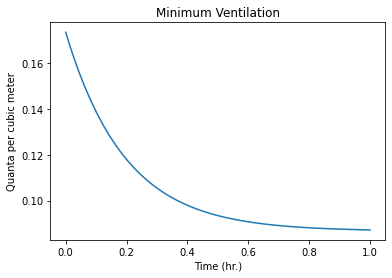

In [14]:
#Now lets estimate quanta concentration
room_dic = get_room_data(sys_path + '/data/masterBuildingData.csv', 'Center Hall', '101')
ach = get_air_changes_per_hour(room_dic['ASHRAE_Airflow'], room_dic['Volume'])
#IVRR is the sum of the deposition rate, inactivation rate, and the Air change rate
ivrr = .63 + .24 + ach
t = 1
def quanta_concentration(t, I = 1, ERq = ERq1, V = room_dic['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('Minimum Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, t)
ax.plot(x, f2(x));

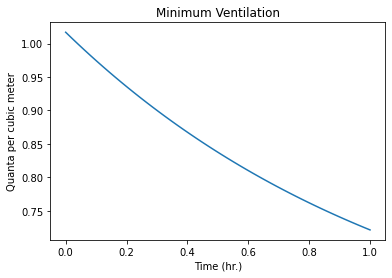

In [15]:
ivrr = .63 + .24
def quanta_concentration(t, I = 1, ERq = ERq1, V = room_dic['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('Minimum Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, t)
ax.plot(x, f2(x));

As we can see ventilation versus no ventilation is the difference between exponential decay of pathogenic material in the air and more linear decay

With our infection_risk function, calculating the infection_risk can be done simply by inputing the duration of the event, the building, room id, number of occupants, activity, and mask wearing (True or False).
The average of two risks can be used to get the risk associated with doing both sets of activities. 

In [26]:
#Infection Risk
walking_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'light_exercise', 'speaking', False, sys_path + '/data/masterBuildingData.csv')
sitting_whisper_risk = infection_risk(t, 'Center Hall', '101', 50, 'resting', 'whispering', False, sys_path + '/data/masterBuildingData.csv')
average_risk = (walking_talking_risk + sitting_whisper_risk) /2

It is estimated that an individual has 1.7540425442991503% chance to be infected
It is estimated that 0.017540425442991503 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.014605772984221943% chance to be infected
It is estimated that 0.00014605772984221943 x 50 = 0 susceptible occupants will be infected


In [17]:
average_risk

0.008843241586416861

Now we can estimate the relative risks associated with difference activities, shown below

It is estimated that an individual has 0.22285722611271597% chance to be infected
It is estimated that 0.0022285722611271597 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.27059402794856746% chance to be infected
It is estimated that 0.0027059402794856746 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 1.7540425442991503% chance to be infected
It is estimated that 0.017540425442991503 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 5.002177964381471% chance to be infected
It is estimated that 0.05002177964381471 x 50 = 2 susceptible occupants will be infected
It is estimated that an individual has 9.624064015586221% chance to be infected
It is estimated that 0.0962406401558622 x 50 = 4 susceptible occupants will be infected


<BarContainer object of 5 artists>

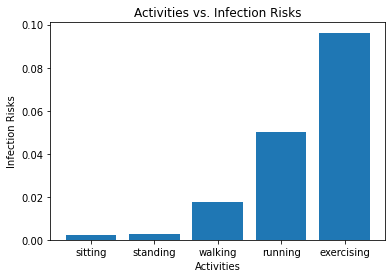

In [18]:
sitting_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'resting', 'speaking', False, sys_path + '/data/masterBuildingData.csv')
standing_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'speaking', False, sys_path + '/data/masterBuildingData.csv')
walking_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'light_exercise', 'speaking', False, sys_path + '/data/masterBuildingData.csv')

running_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'moderate_exercise', 'speaking', False, sys_path + '/data/masterBuildingData.csv')

exercising_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'heavy_exercise', 'speaking', False, sys_path + '/data/masterBuildingData.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Activities')
plt.ylabel('Infection Risks')
plt.title('Activities vs. Infection Risks')
actno = ["sitting", "standing", "walking", "running", "exercising"]
risks = [sitting_talking_risk, standing_talking_risk, walking_talking_risk, running_talking_risk, exercising_talking_risk]
ax.bar(actno, risks)

It is estimated that an individual has 0.27059402794856746% chance to be infected
It is estimated that 0.0027059402794856746 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.07310923392100932% chance to be infected
It is estimated that 0.0007310923392100932 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.017738345210016604% chance to be infected
It is estimated that 0.00017738345210016604 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.4676885342010051% chance to be infected
It is estimated that 0.004676885342010051 x 50 = 0 susceptible occupants will be infected
It is estimated that an individual has 0.015381204623698963% chance to be infected
It is estimated that 0.00015381204623698963 x 50 = 0 susceptible occupants will be infected


<BarContainer object of 5 artists>

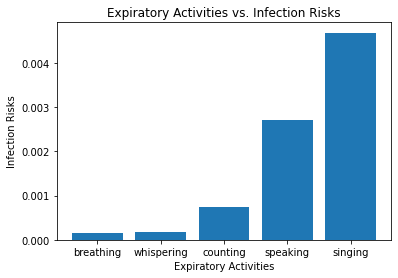

In [19]:
speaking = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'speaking', False, sys_path + '/data/masterBuildingData.csv')
counting = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'counting', False, sys_path + '/data/masterBuildingData.csv')
whispering = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'whispering', False, sys_path + '/data/masterBuildingData.csv')
singing = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'singing', False, sys_path + '/data/masterBuildingData.csv')
breathing = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'breathing', False, sys_path + '/data/masterBuildingData.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Expiratory Activities')
plt.ylabel('Infection Risks')
plt.title('Expiratory Activities vs. Infection Risks')
actno = ["breathing", "whispering", "counting", "speaking", "singing"]
risks = [breathing, whispering, counting, speaking, singing]
ax.bar(actno, risks)

### Results and Discussion

The purpose of this calculator is to give building users a better understanding of how infection can be spread. Our findings give insight into effective methods for mitigating infection risk in indoor environments. A significant driver in infection risk is the type of physical activity. Heavier breathing increases risk of infection exponentially. Likewise more intense expiratory activity like speaking loudly or singing would increase risk of infection. A large factor in risk mitigation is ventilation. No ventilation at all, we observed, causes a linear decrease in quanta concentration, while minimal ventilation will produce an exponential decrease. 

Unfortunately the effect of social distancing and mask wearing was not directly addressed by this model. Social distancing was indirectly addressed by the assumed 1.5m (>6ft) distance from the emission source in calculating deposition rate. In other words, the deposition rate does not account for pathogenic material depositing on another person in the final risk estimation.

It is important to note that our model of quanta concentration assumes that the air change will begin at t = 0 so the quanta concentration will continue to decrease over time. This implies the building HVAC system would ventilate in a constant fashion. In reality, HVAC systems tend to work in a cyclical fashion, providing short spurts of air to maintain stable temperatures. Below is an figure from Gupta et al. "Zonal Air Handling in Commercial Buildings" depicting this behavior. 
![title](images/supplyairflow.png)
This model does not yet reflect this cyclical nature.

Additionally, the assumptions used to produce this model are limited to the existing academic literature regarding the novel coronavirus. For example, the quanta per RNA copy assumed in our model was taken from literature regarding SARS-CoV-1, not SARS-CoV2, because such information does not currently exist.  

Also, the infection rate is a constantly changing value, and is not currently up to date in our assumptions.

## Room Data

In order to provide an easy to use application for users at UC San Diego we decided to provide room information so it does not have to be imputed by the user. 
The process for getting the room data involved pulling it from the university's building database, selecting areas that would be used commonly by building occupants (e.g. offices, classrooms, laboratories, etc.), and imputing room information based on the use. 

Below is the data in its raw form:

In [24]:
pd.read_csv('fm_building_data/BiologyBuildingRooms.csv').head()

,Building,Floor,Suite,Room,Space,Pct,Area,Stations,Category,Description,Room Use (S),CPEC Code,Department,Program,System (S/C/R),Cost Codes,PI/Manager,Occupants,Utilization,Home Page
0,Biology Building,Basement,NaN,(C)B030A,NaN,100%,1007,NaN,C - Public Circulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://facilities.ucsd.edu/Buildings/Rooms/Ho...
1,Biology Building,Basement,NaN,(C)B030B,NaN,100%,559,NaN,C - Public Circulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://facilities.ucsd.edu/Buildings/Rooms/Ho...
2,Biology Building,Basement,NaN,(CE)B040,NaN,100%,152,NaN,C - Public Circulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://facilities.ucsd.edu/Buildings/Rooms/Ho...
3,Biology Building,Basement,NaN,(CS)B030C,NaN,100%,100,NaN,C - Public Circulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://facilities.ucsd.edu/Buildings/Rooms/Ho...
4,Biology Building,Basement,NaN,(J)B036,NaN,100%,32,NaN,J - Custodial Support,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://facilities.ucsd.edu/Buildings/Rooms/Ho...


To process the data, relevant rooms were selected and placed into [ASHRAE](https://www.ashrae.org/about) categories based on room use. From there the occupancy was imputed if not already provided, then the room area and room occupancy are used to determine the ASHRAE standard airflow rate. An average height of 10 ft. is currently imputed for all rooms.

Below is the processed data

In [31]:
pd.read_csv(sys_path + '/data/masterBuildingData.csv').head()

,Unnamed: 0,Building,Room,Area,heightImputed,Occupancy,occupancyImputed_TF,ASHRAE_Airflow,maxAirflow
0,0,Mandeville Center,B202,3070,10,15.35,True,260.95,NaN
1,1,Mandeville Center,B206,1959,10,40.00,False,417.54,NaN
2,2,Mandeville Center,B210,3091,10,158.00,False,1370.46,NaN
3,3,Mandeville Center,B104,864,10,42.00,False,366.84,NaN
4,4,Mandeville Center,B108,864,10,6.00,False,96.84,NaN
